In [115]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, SampleSet2D
from multiple_chains import MultipleChains
from tqdm import tqdm

In [116]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .90

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

# n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [117]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 2.03 and 5.97
The Credible Interval for y is between 0.52 and 3.48


In [118]:
# CHOLESKY SAMPLING

# samples_ch = SampleSet(n.cholesky_sample(20000))
# samples_ch.samples_plot(.95, kind='hist')

In [119]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 5
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 200

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

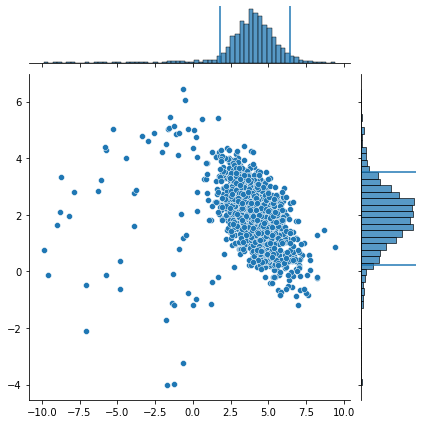

In [120]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

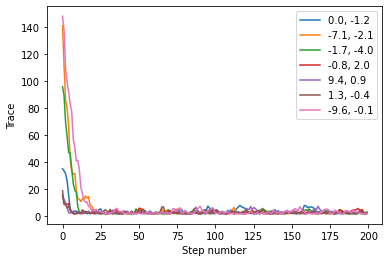

In [121]:
mh.traces_plot(every=1)

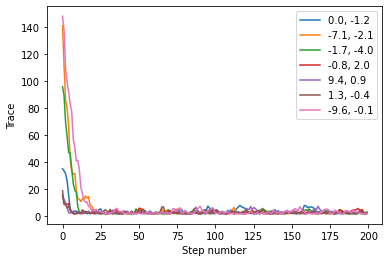

In [122]:
# mh.trim_chains(mh.optimal_trimming)

mh.traces_plot(every=1)

In [123]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[1.0673746  1.15714973]
 [1.15714973 1.06095069]]
[1.0266711919868843, 1.0741303024642497, 1.0350974845062921, 1.0203980092917138, 1.0566606127834446, 1.0217293111905088, 1.0749048457594534]


In [124]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [125]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)
g.trim_chains(g.optimal_trimming)

All thresholds too low!
Trimming at 0


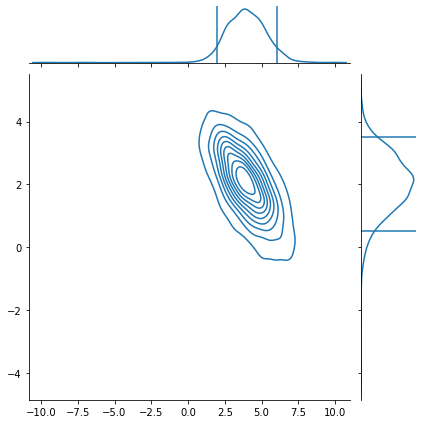

In [126]:
# g.traces_plot()
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [127]:
errors_mh_mean = []
errors_mh_cov = []
errors_g_mean = []
errors_g_cov = []
errors_mh_cov_single = []
errors_g_cov_single = []

chain_length = 10
g_1 = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)
# mh_1 = MultipleChains(MetropolisHastings, n.pdf, initial_positions, chain_length, gaussian_proposal)

N = np.geomspace(chain_length, int(2e6), dtype=int, num=200)
diffs = np.ediff1d(N, to_end=0) # discrete gradient of N
trimming_index = 40

for i, diff in tqdm(enumerate(diffs)):
    # errors_mh_mean.append(np.average(np.sqrt((mh_1.average_mean - n.mean)**2)))
    # errors_mh_cov.append(np.average(np.sqrt((mh_1.average_covariance - n.cov)**2)))
    # errors_g_mean.append(np.average(np.sqrt((g_1.average_mean - n.mean)**2)))
    # errors_g_cov.append(np.average(np.sqrt((g_1.average_covariance - n.cov)**2)))
    # errors_mh_cov_single.append(np.abs(mh_1.average_covariance - n.cov))
    errors_g_cov_single.append(np.abs(g_1.average_covariance - n.cov))

    if i == trimming_index:
        g_1.trim_chains(g_1.optimal_trimming)
        # mh_1.trim_chains(mh_1.optimal_trimming)

    g_1.extend_chains(diff)
    # mh_1.extend_chains(diff)

# errors_mh_cov_single = np.array(errors_mh_cov_single)
errors_g_cov_single = np.array(errors_g_cov_single)

40it [00:05,  6.37it/s]Trimming at 2
200it [1:29:21, 26.81s/it] 


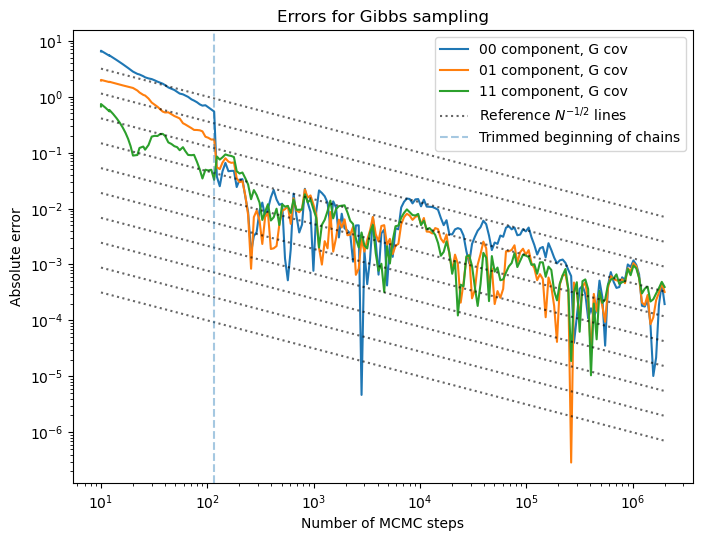

In [132]:
plt.figure(dpi=100, figsize=(8, 6))
# plt.loglog(N, errors_mh_cov, label = 'MH cov')
# plt.loglog(N, errors_g_cov, label = 'G cov')
# plt.loglog(N, errors_mh_mean, label = 'MH mean')
# plt.loglog(N, errors_g_mean, label = 'G mean')
for i in range(2):
    for j in range(2):
        if i <= j:
            # plt.loglog(N, errors_mh_cov_single[:, i, j], label = f'{i}{j} component, MH cov')
            plt.loglog(N, errors_g_cov_single[:, i, j], label = f'{i}{j} component, G cov')
            # pass


leg = 'Reference $N^{-1/2}$ lines'
for C in np.logspace(1, -3, num=10):
    plt.plot(N, N**(-1/2) * C, ls=':', c='black', alpha=.6, label=leg)
    leg=None

plt.axvline(N[trimming_index], ls='--', alpha = .4, label='Trimmed beginning of chains')

plt.legend()
plt.title('Errors for Gibbs sampling')
plt.xlabel('Number of MCMC steps')
plt.ylabel('Absolute error')
plt.savefig('gibbs_cov_error_scaling.pdf')

In [129]:
mh_1.average_covariance - n.cov

array([[0.00706253, 0.01793976],
       [0.01793976, 0.02324375]])